In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.callbacks import TensorBoard
import sklearn as sk
from sklearn import metrics
import tensorflow as tf
import tensorflow_hub as hub

Constantes a definir

In [2]:
RUTA_TRAIN = "./tfg_dataset/train"
RUTA_TEST = "./tfg_dataset/test"
DIM = 224
BATCH_SIZE = 32
VALIDATION_SPLIT = .2

Funciones para visualizar un ejemplo del dataset creado con `image_dataset_from_directory` y con `flow_from_directory`

In [3]:
def sample_ds_dfd(ds): 
    for i, (img, label) in enumerate(ds.unbatch().take(9)): 
        plt.subplot(3, 3, i + 1)
        plt.imshow(img.numpy())
        plt.title(ds.class_names[np.argmax(label)], fontsize = 8)
        plt.axis("off")

def sample_ds_ffd(ds): 
    for i, (img, label) in enumerate(zip(ds[0][0], ds[0][1])):
        if i == 9: break
        plt.subplot(3, 3, i + 1)
        plt.title(dict(zip(ds.class_indices.values(), ds.class_indices.keys()))[np.argmax(label)], fontsize = 8)
        plt.imshow(img)
        plt.axis("off")

Se crea un dataset con todas las imágenes del directorio. Se elige un tamaño de batch, pero al entrenar se puede especificar otro (utiliza el menor de los dos). 

In [4]:
x_train, x_val = image_dataset_from_directory(
    directory = RUTA_TRAIN,
    image_size = (DIM, DIM), 
    labels = "inferred",
    label_mode = "categorical", 
    batch_size = BATCH_SIZE, 
    validation_split = VALIDATION_SPLIT,
    subset = "both",
    seed = 123
)

Found 586 files belonging to 4 classes.
Using 469 files for training.
Using 117 files for validation.


De manera similar se realiza para los datos utilizados para evaluar el modelo. 

In [5]:
x_test = image_dataset_from_directory(
    directory = RUTA_TEST,
    image_size = (DIM, DIM), 
    labels = "inferred",
    label_mode = "categorical", 
    batch_size = BATCH_SIZE, 
    shuffle = False
)

Found 102 files belonging to 4 classes.


Se normalizan los valores de las imágenes para facilitar el trabajo a la red

In [6]:
class_names = x_train.class_names
norm = tf.keras.layers.Rescaling(1./255)
x_train = x_train.map(lambda x, y: (norm(x), y))
x_val = x_val.map(lambda x, y: (norm(x), y))
x_test = x_test.map(lambda x, y: (norm(x), y))
x_train.class_names = class_names
x_val.class_names = class_names
x_test.class_names = class_names

Se muestran algunos ejemplos del dataset

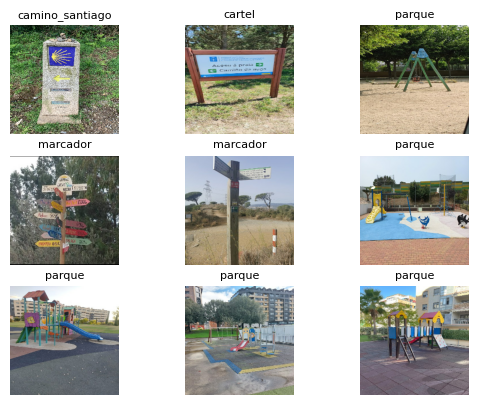

In [7]:
sample_ds_dfd(x_train)

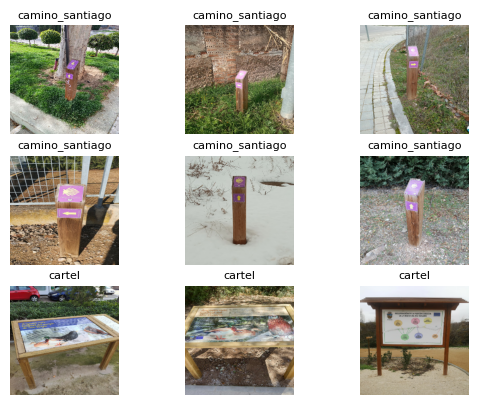

In [8]:
sample_ds_dfd(x_test)

Se crea un modelo basado en uno ya entrenado de TensorHub

In [9]:
thub_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
red_mb = tf.keras.Sequential([
    hub.KerasLayer(thub_model, input_shape = (DIM, DIM, 3), trainable = False),
    tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
])
red_mb.summary()
red_mb.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________



Se realiza el entrenamiento del modelo

In [10]:
%load_ext tensorboard
red_mb.fit(x_train, epochs = 25, validation_data = x_val, callbacks = [TensorBoard(log_dir = "logs_mobilenet")])

Epoch 1/25



15/15 [==============================] - 8s 287ms/step - loss: 0.9504 - accuracy: 0.6119 - val_loss: 0.4398 - val_accuracy: 0.8803
Epoch 2/25
15/15 [==============================] - 4s 254ms/step - loss: 0.3069 - accuracy: 0.9339 - val_loss: 0.2086 - val_accuracy: 0.9573
Epoch 3/25
15/15 [==============================] - 4s 251ms/step - loss: 0.1696 - accuracy: 0.9595 - val_loss: 0.1294 - val_accuracy: 0.9658
Epoch 4/25
15/15 [==============================] - 4s 249ms/step - loss: 0.1177 - accuracy: 0.9787 - val_loss: 0.1085 - val_accuracy: 0.9658
Epoch 5/25
15/15 [==============================] - 4s 251ms/step - loss: 0.0900 - accuracy: 0.9893 - val_loss: 0.0897 - val_accuracy: 0.9744
Epoch 6/25
15/15 [==============================] - 4s 252ms/step - loss: 0.0730 - accuracy: 0.9915 - val_loss: 0.0794 - val_accuracy: 0.9658
Epoch 7/25
15/15 [==============================] - 5s 295ms/step - loss: 0.0602 - accuracy: 0.9915 - val_loss: 0.0709 - val_accuracy: 0.9744
Epoch 8/25
15/15 

Se hacen las predicciones sobre el conjunto de test para evaluar el modelo

In [11]:
def predict_dataset(ds, modelo): 
    y_target = []
    y_hat = []
    y_confidence = []
    batches = len(ds)
    for batch, (img_batch, label_batch) in enumerate(ds): 
        if batch == batches: 
            break
        else: 
            for img, label in zip(img_batch, label_batch):
                y_target.append(np.argmax(label))
                y_hat.append(np.argmax(modelo.predict(np.expand_dims(img, axis = 0), verbose = 0)[0]))
                y_confidence.append(np.max(modelo.predict(np.expand_dims(img, axis = 0), verbose = 0)))
    return np.column_stack((y_target, y_hat, y_confidence)), modelo.predict(ds, verbose = 0)

Y_matrix, Y_score = predict_dataset(x_test, red_mb)

Se muestran las 9 primeras predicciones como ejemplo

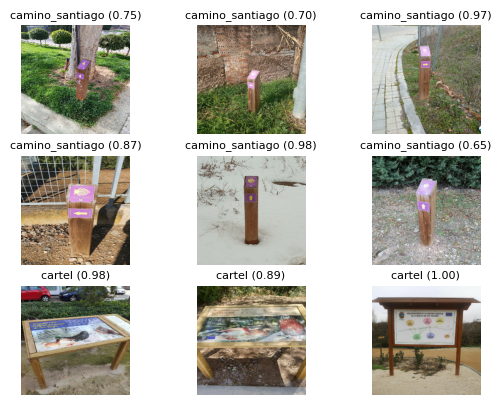

In [12]:
def sample_predict_ds_fd(ds, Y_matrix): 
    for img_batch, _ in ds.take(1):
        for i, img in enumerate(img_batch): 
            prediccion = int(Y_matrix[i, 1])
            plt.subplot(3, 3, i + 1)
            plt.title(f"{ds.class_names[prediccion]} ({Y_matrix[i, 2]:.2f})", fontsize = 8)
            plt.imshow(img.numpy())
            plt.axis("off")
            if i == 8: 
                break

sample_predict_ds_fd(x_test, Y_matrix)

### Métricas
¿Realmente ha sido un buen modelo? 
#### Matriz de confusión

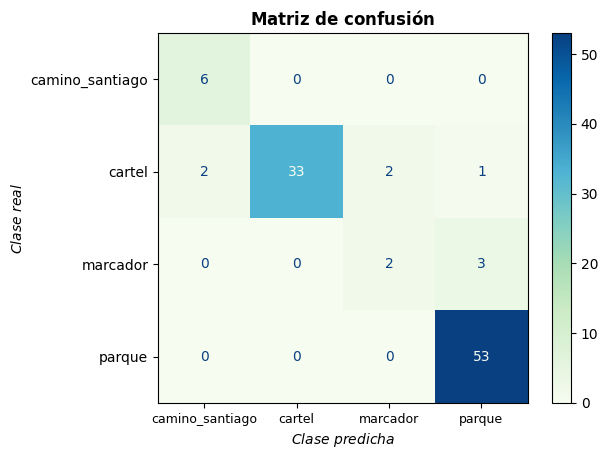

In [13]:
def matriz_confusion(ds, Y_matrix): 
    cm = sk.metrics.confusion_matrix(Y_matrix[:, 0], Y_matrix[:, 1])
    diagrama = sk.metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ds.class_names).plot(
        include_values = True, 
        cmap = plt.cm.GnBu, 
        ax = plt.gca()
    )
    diagrama.ax_.set_title(r"$\mathbf{Matriz\ de\ confusión}$")
    diagrama.ax_.set_xlabel(r"$\mathit{Clase\ predicha}$")
    diagrama.ax_.set_ylabel(r"$\mathit{Clase\ real}$")
    diagrama.ax_.tick_params(axis = "x", labelsize = 9)

matriz_confusion(x_test, Y_matrix)

#### Resumen de métricas

* **Precisión**: de todos los elementos clasificados como $C_i$, ¿cuántos realmente pertenecen a dicha clase?
$$
\mathcal{P} = P(C_i | \hat{C}_i) = \frac{P(C_i \cap \hat{C}_i)}{P(\hat{C}_i)}
$$

* **Sensibilidad**: de todos los elementos de la clase $C_i$, ¿cuántos se han clasificado como tal?
$$
\mathcal{R} = P(\hat{C}_i | C_i) = \frac{P(\hat{C}_i \cap C_i)}{P(C_i)}
$$

* $F_1-$ Score: en general, ¿cómo de bueno es el clasificador?
$$
F_1 = \frac{2}{\mathcal{P}^{-1} + \mathcal{R}^{-1}}
$$

In [14]:
def metricas_matriz_confusion(ds, Y_matrix, dict = False):
    return sk.metrics.classification_report(
                                 Y_matrix[:, 0], Y_matrix[:, 1], 
                                 target_names = ds.class_names, 
                                 digits = 3, 
                                 output_dict = dict
                                )

print(metricas_matriz_confusion(x_test, Y_matrix))

                 precision    recall  f1-score   support

camino_santiago      0.750     1.000     0.857         6
         cartel      1.000     0.868     0.930        38
       marcador      0.500     0.400     0.444         5
         parque      0.930     1.000     0.964        53

       accuracy                          0.922       102
      macro avg      0.795     0.817     0.799       102
   weighted avg      0.924     0.922     0.919       102



* Coeficiente $\kappa$ de Cohen: otra manera de medir la calidad del clasificador. 

In [15]:
def kappa_cohen(Y_matrix): 
    return sk.metrics.cohen_kappa_score(Y_matrix[:, 0], Y_matrix[:, 1]).round(3)

kappa_cohen(Y_matrix)

0.865

* Curvas ROC y área AUC: en el caso de varias clases existen diferentes formas de interpretar y calcular las curvas ROC y su AUC. Predominan los algoritmos OvO y OvR. OvO consiste en realizar una media ponderada de los $2\binom{c}{2}$ posibles AUC. Es decir, para cada posible pareja de clases se considera como un caso de clasificación binaria donde se representa $P(\hat{C}_i | C_i)$ frente a $P(\hat{C}_i | C_j)$, y $P(\hat{C}_j | C_j)$ frente a $P(\hat{C}_j | C_i)$ y cada AUC obtenido se pondera respectivamente mediante $P(C_i)$ y $P(C_j)$. De esta manera el mal AUC de una pareja es proporcional al número de observaciones de las clases que compara, siendo útil para casos de clases desbalanceadas como este. 
$$
\mathcal{A}_{\text{ovo}} = \frac{1}{c(c-1)}\sum_{j=1}^c\sum_{k \neq j}^c P(C_j)\mathcal{A}(C_j | C_k) = \frac{1}{c(c-1)}\sum_{j=1}^c\sum_{k > j}^c P(C_j \cup C_k)(\mathcal{A}(C_j | C_k) + \mathcal{A}(C_k | C_j))
$$

In [16]:
sk.metrics.roc_auc_score(Y_matrix[:, 0], Y_score, multi_class = "ovr", average = "weighted")

0.9930581446496124

In [17]:
sk.metrics.roc_auc_score(Y_matrix[:, 0], Y_score, multi_class = "ovo", average = "weighted")

0.9759402050569759

Para hacerlo un poco más ilustrativo, se puede programar una función propia de AUC OvR donde se vean las gráficas correspondientes a las $c$ clases. 

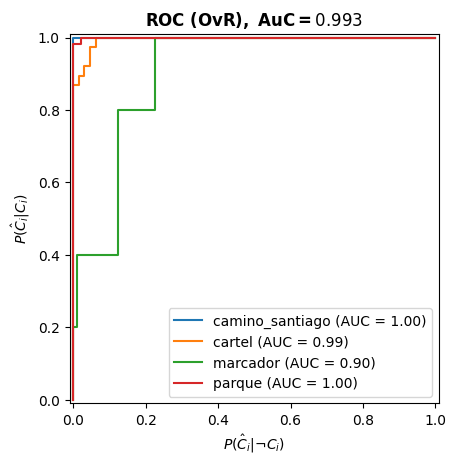

0.9930581446496125

In [18]:
def roc_auc_ovr(Y_matrix, Y_score, clases): 
    Y_ms = np.column_stack((Y_matrix[:, :-1], Y_score))
    _, ax = plt.subplots()
    auc_ovr = 0

    for i in range(Y_score.shape[1]): 
        Y_ms_temp = Y_ms.copy()
        Y_ms_temp[:, 0] = np.where(Y_ms_temp[:, 0] != i, -1, 1)
        fpr, tpr, _ = sk.metrics.roc_curve(y_true = Y_ms_temp[:, 0], y_score = Y_ms_temp[:, i + 2], pos_label = 1)
        auc = sk.metrics.auc(fpr, tpr)
        prop = np.mean(Y_ms_temp[:, 0] == 1)
        auc_ovr += auc * prop
        sk.metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name=f"{clases[i]}").plot(ax = ax)
    
    ax.set_title(r"$\mathbf{ROC\ (OvR),\ AuC = }$" + str(auc_ovr.round(3)))
    ax.set_xlabel(r"$P(\hat{C}_i | \neg C_i)$")
    ax.set_ylabel(r"$P(\hat{C}_i | C_i)$")
    plt.show()
    return auc_ovr

roc_auc_ovr(Y_matrix, Y_score, x_val.class_names)

Se pueden asociar todas en una única función por comodidad: 

In [19]:
def metricas_prediccion(ds, Y_matrix, Y_score): 
    matriz_confusion(ds, Y_matrix)
    print(metricas_matriz_confusion(ds, Y_matrix))
    print(f"Kappa de Cohen: {kappa_cohen(Y_matrix)}")
    print(f"AUC (OvO): {sk.metrics.roc_auc_score(Y_matrix[:, 0], Y_score, multi_class = 'ovo', average = 'weighted').round(3)}")
    print(f"AUC (OvR): {sk.metrics.roc_auc_score(Y_matrix[:, 0], Y_score, multi_class = 'ovr', average = 'weighted').round(3)}")
    roc_auc_ovr(Y_matrix, Y_score, ds.class_names)

Ahora se va a hacer una rápida comparación creando una red convolucional desde cero, y entrenándola también desde cero, para poder destacar el poder del transfer learning. 

In [20]:
red_conv = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", input_shape = (DIM, DIM, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
])
red_conv.summary()
red_conv.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 64)       

Entrenamos el modelo

In [21]:
%load_ext tensorboard
red_conv.fit(x_train, epochs = 25, validation_data = x_val, callbacks = [TensorBoard(log_dir = "logs_cnn")])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/25
15/15 [==============================] - 7s 385ms/step - loss: 1.3656 - accuracy: 0.3902 - val_loss: 1.2889 - val_accuracy: 0.5299
Epoch 2/25
15/15 [==============================] - 6s 366ms/step - loss: 1.0971 - accuracy: 0.6055 - val_loss: 0.9781 - val_accuracy: 0.6068
Epoch 3/25
15/15 [==============================] - 6s 367ms/step - loss: 0.8067 - accuracy: 0.7015 - val_loss: 0.8538 - val_accuracy: 0.6838
Epoch 4/25
15/15 [==============================] - 6s 376ms/step - loss: 0.6676 - accuracy: 0.7697 - val_loss: 0.7650 - val_accuracy: 0.7009
Epoch 5/25
15/15 [==============================] - 6s 366ms/step - loss: 0.5283 - accuracy: 0.8124 - val_loss: 0.9571 - val_accuracy: 0.6838
Epoch 6/25
15/15 [==============================] - 6s 368ms/step - loss: 0.4383 - accuracy: 0.8443 - val_loss: 0.7340 - val_accuracy: 0.7265
Epoch 7/25
15/15 [==============================] - 6s 368

Aplicamos las mismas métricas de evaluación

                 precision    recall  f1-score   support

camino_santiago      0.333     0.167     0.222         6
         cartel      0.848     0.737     0.789        38
       marcador      0.143     0.200     0.167         5
         parque      0.814     0.906     0.857        53

       accuracy                          0.765       102
      macro avg      0.535     0.502     0.509       102
   weighted avg      0.765     0.765     0.760       102

Kappa de Cohen: 0.59
AUC (OvO): 0.81
AUC (OvR): 0.883


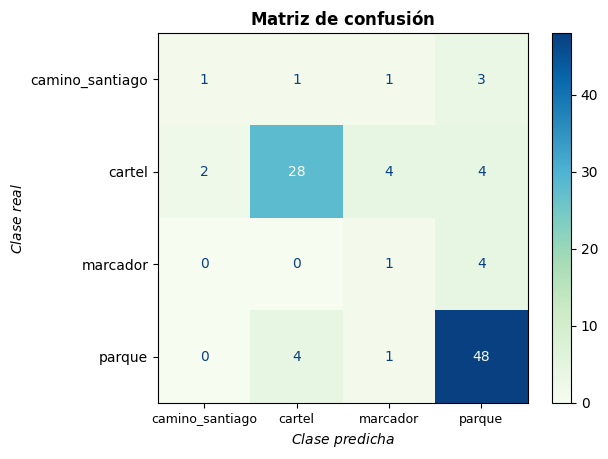

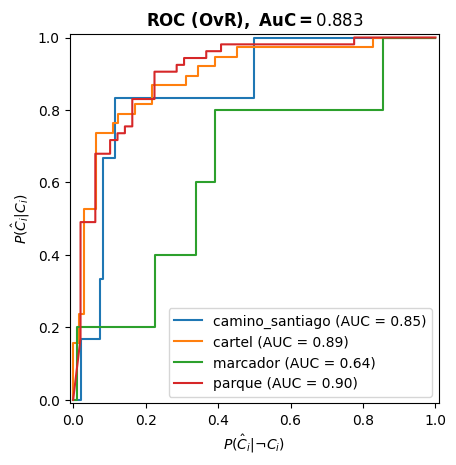

In [22]:
Y_matrix_conv, Y_score_conv = predict_dataset(x_test, red_conv)
metricas_prediccion(x_test, Y_matrix_conv, Y_score_conv)

Se nota que es peor, además de un claro sobreajuste en el entrenamiento, y que este es más costoso. Aún así para haberlo entrenado de cero y teniendo tan pocos datos, no está tan mal. Cuidado también con mirar sólo los AUC, algunos pueden tenerlo alto aún habiendo clasificado mal. Hay que mirarlos junto con el resto de métricas. Se nota como con transfer learning, las capas convolucionales saben qué características obtener de la imagen, aquí no terminan de ser capaces y tienden a memorizar el dataset. 

Se va a proceder a la técnica del aumento de datos. Se va a crear el mismo dataset pero haciendo modificaciones sobre las imágenes, de manera que se reentrene la red aprendiendo a extraer las mismas características de imágenes similares. 

In [23]:
generador_original = ImageDataGenerator(
    rescale = 1/255,
    validation_split = VALIDATION_SPLIT
)

generador_modificado = ImageDataGenerator(
    rotation_range = 20,
    width_shift_range = 0.25,
    height_shift_range = 0.25,
    shear_range = 10,
    zoom_range = [0.25, 1.25],
    rescale = 1/255,
    validation_split = VALIDATION_SPLIT
)

x_train_2 = generador_original.flow_from_directory(RUTA_TRAIN, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "training")

x_val_2 = generador_original.flow_from_directory(RUTA_TRAIN, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "validation")

x_train_au = generador_modificado.flow_from_directory(RUTA_TRAIN, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "training")

x_val_au = generador_modificado.flow_from_directory(RUTA_TRAIN, 
                                                        target_size = (DIM, DIM),
                                                        batch_size = 32, 
                                                        shuffle = True, 
                                                        subset = "validation")

Found 470 images belonging to 4 classes.
Found 116 images belonging to 4 classes.


Found 470 images belonging to 4 classes.
Found 116 images belonging to 4 classes.


Se muestran las imágenes modificadas

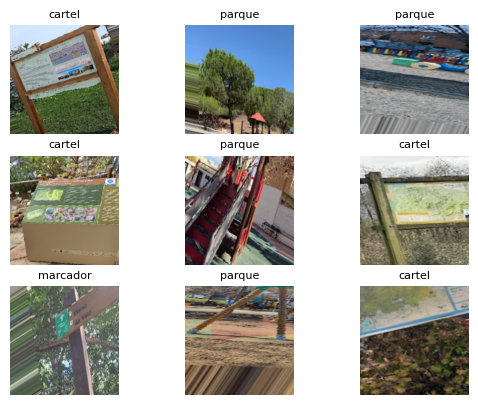

In [32]:
sample_ds_ffd(x_train_au)

Ahora se toman los modelos idénticos a los anteriores y se entrena sobre ellos con el dataset modificado para comprobar si esta técnica aporta diferencias al entrenamiento

In [25]:
red_mb_2 = tf.keras.Sequential([
    hub.KerasLayer(thub_model, input_shape = (DIM, DIM, 3), trainable = False),
    tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
])
red_mb_2.summary()
red_mb_2.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)
red_conv_2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", input_shape = (DIM, DIM, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation = "relu"),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(x_train.class_names), activation = "softmax")
])
red_conv_2.summary()
red_conv_2.compile(
    optimizer = "adam",
    loss = "categorical_crossentropy",
    metrics = ["accuracy"]
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense_2 (Dense)             (None, 4)                 5124      
                                                                 
Total params: 2263108 (8.63 MB)
Trainable params: 5124 (20.02 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)      0         
 g2D)                                                     

In [26]:
%load_ext tensorboard
red_mb_2.fit(x_train_au, epochs = 15, validation_data = x_val_au, callbacks = [TensorBoard(log_dir = "logs_mobilenet_augmented")])
red_mb_2.fit(x_train_2, epochs = 15, validation_data = x_val_2, callbacks = [TensorBoard(log_dir = "logs_mobilenet_augmented")])
red_conv_2.fit(x_train_au, epochs = 15, validation_data = x_val_au, callbacks = [TensorBoard(log_dir = "logs_conv_augmented")])
red_conv_2.fit(x_train_2, epochs = 15, validation_data = x_val_2, callbacks = [TensorBoard(log_dir = "logs_conv_augmented")])

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Epoch 1/15
15/15 [==============================] - 15s 760ms/step - loss: 1.3324 - accuracy: 0.4702 - val_loss: 0.8794 - val_accuracy: 0.6983
Epoch 2/15
15/15 [==============================] - 11s 706ms/step - loss: 0.6968 - accuracy: 0.7745 - val_loss: 0.4393 - val_accuracy: 0.8793
Epoch 3/15
15/15 [==============================] - 11s 709ms/step - loss: 0.4850 - accuracy: 0.8511 - val_loss: 0.3749 - val_accuracy: 0.8966
Epoch 4/15
15/15 [==============================] - 11s 720ms/step - loss: 0.3394 - accuracy: 0.8957 - val_loss: 0.3137 - val_accuracy: 0.8966
Epoch 5/15
15/15 [==============================] - 11s 705ms/step - loss: 0.3271 - accuracy: 0.8957 - val_loss: 0.3062 - val_accuracy: 0.8966
Epoch 6/15
15/15 [==============================] - 10s 700ms/step - loss: 0.3125 - accuracy: 0.8894 - val_loss: 0.1845 - val_accuracy: 0.9569
Epoch 7/15
15/15 [==============================] - 

En caso de que se tengan pocos datos y malos resultados es una técnica que ayuda a mejorar. Cuidado porque también puede dar lugar a overfitting. A continuación se evalúa con las métricas empleadas previamente. 

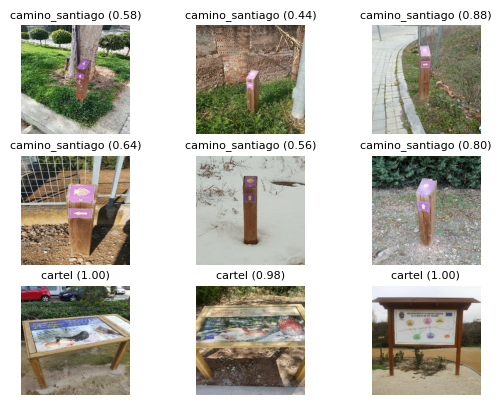

In [27]:
Y_matrix_mbau, Y_score_mbau = predict_dataset(x_test, red_mb_2)
sample_predict_ds_fd(x_test, Y_matrix_mbau)

                 precision    recall  f1-score   support

camino_santiago      0.857     1.000     0.923         6
         cartel      0.972     0.921     0.946        38
       marcador      0.333     0.200     0.250         5
         parque      0.946     1.000     0.972        53

       accuracy                          0.931       102
      macro avg      0.777     0.780     0.773       102
   weighted avg      0.921     0.931     0.924       102

Kappa de Cohen: 0.881
AUC (OvO): 0.97
AUC (OvR): 0.991


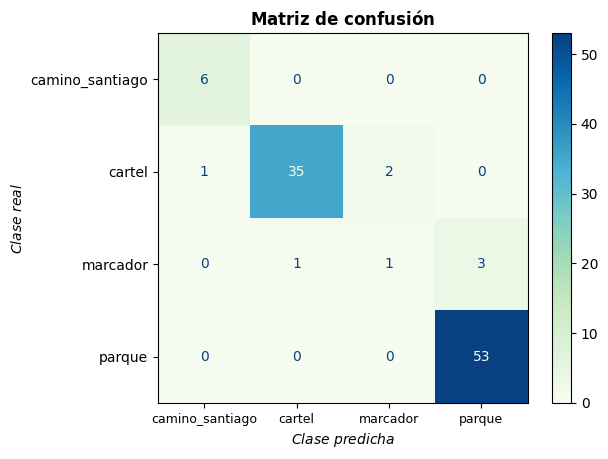

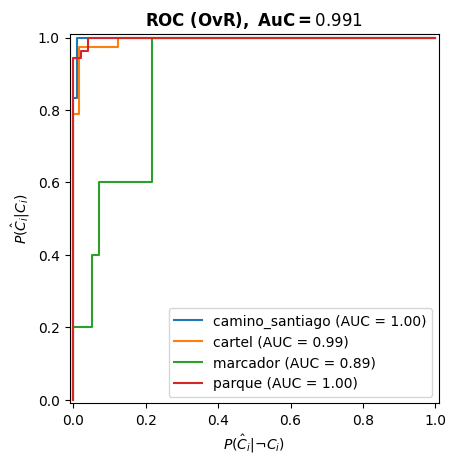

In [28]:
metricas_prediccion(x_test, Y_matrix_mbau, Y_score_mbau)

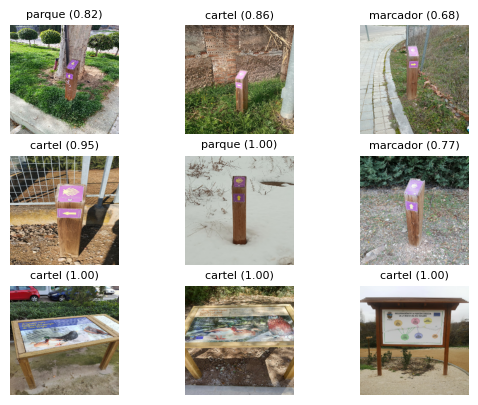

In [29]:
Y_matrix_convau, Y_score_convau = predict_dataset(x_test, red_conv_2)
sample_predict_ds_fd(x_test, Y_matrix_convau)

                 precision    recall  f1-score   support

camino_santiago      0.000     0.000     0.000         6
         cartel      0.829     0.763     0.795        38
       marcador      0.375     0.600     0.462         5
         parque      0.831     0.925     0.875        53

       accuracy                          0.794       102
      macro avg      0.509     0.572     0.533       102
   weighted avg      0.759     0.794     0.773       102

Kappa de Cohen: 0.637
AUC (OvO): 0.91
AUC (OvR): 0.918


c:\Users\pgarc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pgarc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pgarc\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

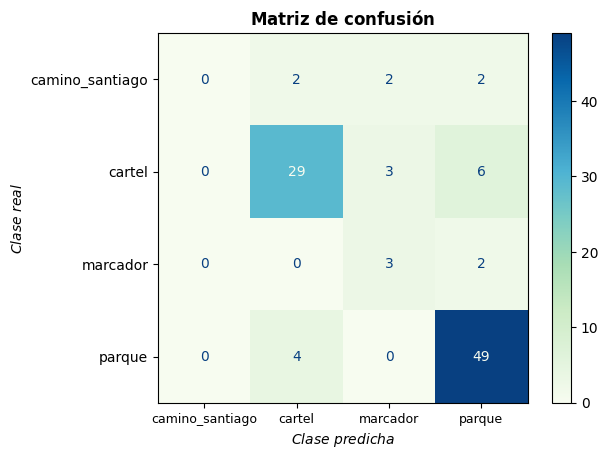

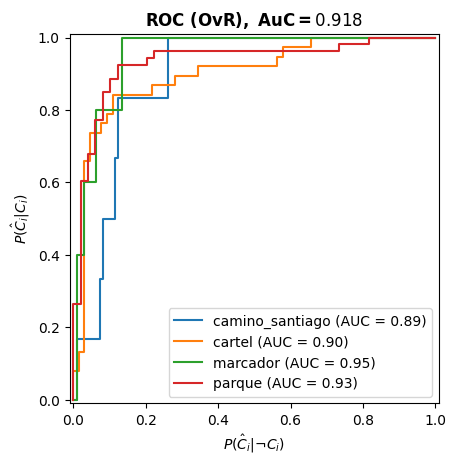

In [31]:
metricas_prediccion(x_test, Y_matrix_convau, Y_score_convau)